# [NTDS'18] Project: Spammer on social network detection 
[ntds'18]: https://github.com/mdeff/ntds_2018


### Jupyter notebook for CLASSIFICATION

## Students

* Team: `20`
* Students: `Fendri Hedi, Jeha Paul, Nguyen Minh Nguyet, Mantonanaki Christina`
* Dataset: `Spammers`

**This notebook take all the created dataset with content and graph based features in order to perform classification**

## A. Importing Library 

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import networkx as nx
import collections
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
import warnings

from sklearn.svm import SVC
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from  sklearn.cluster import KMeans
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  average_precision_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

## B. Preparing the matrix for classification 

**Importing the created dataset in the graph_based.ipynb**

In [2]:
nodes_all=pd.read_csv('datasets_final2.csv')

In [3]:
len(nodes_all)

783122

**Since the dataset is very huge , to reduce the computational time, we sub-sampled the datased to 
52 053 nodes with 29440 non spammers and 22613 spammers**

In [6]:
nodes_sub=nodes_all.drop(nodes_all.query("label== 0").sample(frac=0.96).index)

nodes_sub2=nodes_sub.drop(nodes_sub.query("label== 1").sample(frac=0.52).index)
print("Total of reamaing nodes: ",len(nodes_sub2))

Total of reamaing nodes:  52053


In [9]:
print("Number of spammers: ",np.sum(nodes_sub2["label"]==1))
print("Number of non spammers: ",np.sum(nodes_sub2["label"]==0))

Number of spammers:  22613
Number of non spammers:  29440


**Create the numpy matrix for classification**

In [10]:
labels_train=nodes_sub2['label']
nodes_train=nodes_sub2.drop(['label'],axis=1)
nodes_for_train=nodes_train['node'].values
nodes_train=nodes_train.drop(['node'],axis=1)

In [11]:
nodes_train=nodes_train.drop(['out_deg_1'],axis=1)
nodes_train=nodes_train.drop(['out_deg_2'],axis=1)
nodes_train=nodes_train.drop(['out_deg_5'],axis=1)
nodes_train=nodes_train.drop(['out_deg_4'],axis=1)
nodes_train=nodes_train.drop(['out_deg_7'],axis=1)
nodes_train=nodes_train.drop(['in_deg_4'],axis=1)
nodes_train=nodes_train.drop(['in_deg_5'],axis=1)
nodes_train=nodes_train.drop(['in_deg_2'],axis=1)
nodes_train=nodes_train.drop(['in_deg_1'],axis=1)
nodes_train=nodes_train.drop(['in_deg_7'],axis=1)
nodes_train=nodes_train.drop(['deg_4'],axis=1)
nodes_train=nodes_train.drop(['deg_5'],axis=1)
nodes_train=nodes_train.drop(['deg_2'],axis=1)
nodes_train=nodes_train.drop(['deg_1'],axis=1)
nodes_train=nodes_train.drop(['deg_7'],axis=1)

In [12]:
nodes_train.loc[nodes_train['gender'] =='M', 'gender'] = 1
nodes_train.loc[nodes_train['gender'] =='F', 'gender'] = 0

In [13]:
X_all=nodes_train.values
Y_all=labels_train.values
X_all.shape

(52053, 33)

**Filling the missing values (NaN) with the mean on columns**

In [14]:
imp=preprocessing.Imputer(missing_values='NaN', strategy='mean')

In [15]:
#X_all=imp.fit_transform(X_all)

**Or trying to replace NaN by simply zeros**

In [16]:
X_all=np.nan_to_num(X_all)

**Splitting the hole dataset to training and testing with ratio=0.35**

In [17]:
num_test = 0.35
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=num_test, random_state=23)
#X_scaled = preprocessing.scale(X_train)
X_scaled=X_train
y_train.shape

(33834,)

## C. Classification with only content based features

In [18]:
def evaluate_method(y_true,y_pred): 
    """ Evaluating the model using f-measure and accuracy
     Parameters
    ----------
        y_true  : True labels

        y_pred  : Predicted labels
                    
    Returns : None
    
    """
    f1=metrics.f1_score(y_true, y_pred)
    acc=metrics.accuracy_score(y_true, y_pred)
    print("F-measure= ",f1)
    print("Accuracy= ",acc)
    

In [24]:
def plot_roc(y_true,y_pred):
    """ Plotting Roc curve 
     Parameters
    ----------
        y_true  : True labels

        y_pred  : Predicted labels
                    
    Returns : None
    
    """
    auc=roc_auc_score(y_true, y_pred)
    print('auc=',auc)
    fpr,tpr,_=roc_curve(y_true, y_pred)
    plt.plot(fpr,tpr)

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    t=plt.title('Receiver operating characteristic')
    

In [77]:
def plot_prec_recall_curve(y_true, y_pred):
    precision, recall, thresholds=precision_recall_curve(y_true, y_pred)
    plt.plot(recall,precision)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    t=plt.title('Precision recall curve')
    print("AUPR= ",average_precision_score(y_true, y_pred))

## Let's try to classify  using Age range and Gender

In [20]:
X_train_content=X_train[:,1:3]
X_test_content=X_test[:,1:3]
X_test_content.shape

(18219, 2)

### 1) Using K-NN 

**Tuning Hyperparameter K**

In [88]:
neigbors = [1,3,5,7,11,13,15,17,21,31,51,81,101,301,501,701,1001]
param_grid = {'n_neighbors': neigbors}      
print("# Tuning hyper-parameters for f_measure")
print()
clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                   scoring='f1')
clf.fit(X_train_content, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for f_measure

Best parameters set found on development set:

{'n_neighbors': 1001}

Grid scores on development set:

0.510 (+/-0.117) for {'n_neighbors': 1}
0.561 (+/-0.071) for {'n_neighbors': 3}
0.558 (+/-0.094) for {'n_neighbors': 5}
0.538 (+/-0.099) for {'n_neighbors': 7}
0.528 (+/-0.087) for {'n_neighbors': 11}
0.511 (+/-0.091) for {'n_neighbors': 13}
0.481 (+/-0.022) for {'n_neighbors': 15}
0.496 (+/-0.078) for {'n_neighbors': 17}
0.480 (+/-0.024) for {'n_neighbors': 21}
0.511 (+/-0.098) for {'n_neighbors': 31}
0.527 (+/-0.092) for {'n_neighbors': 51}
0.562 (+/-0.011) for {'n_neighbors': 81}
0.562 (+/-0.011) for {'n_neighbors': 101}
0.562 (+/-0.011) for {'n_neighbors': 301}
0.562 (+/-0.011) for {'n_neighbors': 501}
0.564 (+/-0.008) for {'n_neighbors': 701}
0.566 (+/-0.012) for {'n_neighbors': 1001}



**Training KNN**

In [21]:
clf3=KNeighborsClassifier(n_neighbors=1001)
clf3.fit(X_train_content, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1001, p=2,
           weights='uniform')

**Prediction and performance evaluation**

In [22]:
y_pred_knn_cont=clf3.predict(X_test_content)
evaluate_method(y_test,y_pred_knn_cont)

F-measure=  0.5670508661743392
Accuracy=  0.6556891157582744


**Plotting roc curve**

auc= 0.6397771077409827


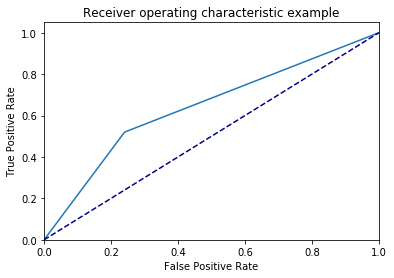

In [25]:
plot_roc(y_test,y_pred_knn_cont)

### 2) Support vector machine classifier

In [26]:
Cs = [0.001, 0.01, 0.1, 1,10,50]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

In [ ]:
warnings.filterwarnings('ignore')


print("# Tuning hyper-parameters")
print()
clf = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5,
                   scoring='f1')
clf.fit(X_train_content, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters



**Training predicting and computing performance**

In [32]:

clf2=SVC(C=50, kernel='rbf', gamma=0.001)
clf2.fit(X_train_content, y_train)
y_pred_svm_content=clf2.predict(X_test_content)
evaluate_method(y_test,y_pred_svm_content)


F-measure=  0.5609362389023406
Accuracy=  0.6416927383500741


**Plotting ROC curve**

auc= 0.628345113009395


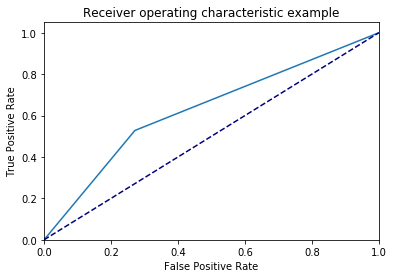

In [33]:
plot_roc(y_test,y_pred_svm_content)

### 3) Linear discriminant analysis (LDA)

In [41]:
clf5=LDA(n_components=1) 
clf5.fit(X_train_content,y_train)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

**Training, prediction and measuring performance**

F-measure=  0.5609362389023406
Accuracy=  0.6416927383500741
auc= 0.628345113009395


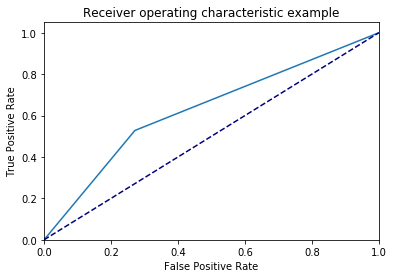

In [43]:
y_pred_lda=clf5.predict(X_test_content)
evaluate_method(y_test,y_pred_lda)
plot_roc(y_test,y_pred_lda)

### 4) Random Forest

**Tuning Hyper-parameters**

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier()


In [55]:
rf=RandomForestClassifier(bootstrap=True,max_depth=30,max_features=2,min_samples_leaf=30,min_samples_split=100,n_estimators=1000)

In [56]:
X_test_content.shape

(18219, 2)

In [57]:
rf.fit(X_train_content, y_train)
y_pred_rf=rf.predict(X_test_content)

F-measure=  0.5646959221109074
Accuracy=  0.6613425544760964
auc= 0.6431915359944024


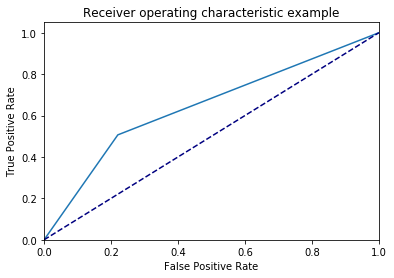

In [58]:
evaluate_method(y_test,y_pred_rf)
plot_roc(y_test,y_pred_rf)

### Let's add time validation as a feature and see the difference 

In [62]:
X_train_content=X_train[:,0:3]
X_test_content=X_test[:,0:3]
X_test_content.shape

(18219, 3)

### 1) K-NN

In [63]:
neigbors = [1,3,5,7,11,13,15,17,21,31,51,81,101,301,501,701,1001]
param_grid = {'n_neighbors': neigbors}      
print("# Tuning hyper-parameters for f_measure")
print()
clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                   scoring='f1')
clf.fit(X_train_content, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for f_measure

Best parameters set found on development set:

{'n_neighbors': 701}

Grid scores on development set:

0.604 (+/-0.032) for {'n_neighbors': 1}
0.607 (+/-0.020) for {'n_neighbors': 3}
0.618 (+/-0.014) for {'n_neighbors': 5}
0.628 (+/-0.021) for {'n_neighbors': 7}
0.632 (+/-0.023) for {'n_neighbors': 11}
0.635 (+/-0.015) for {'n_neighbors': 13}
0.634 (+/-0.018) for {'n_neighbors': 15}
0.635 (+/-0.019) for {'n_neighbors': 17}
0.642 (+/-0.013) for {'n_neighbors': 21}
0.641 (+/-0.013) for {'n_neighbors': 31}
0.644 (+/-0.008) for {'n_neighbors': 51}
0.645 (+/-0.011) for {'n_neighbors': 81}
0.645 (+/-0.009) for {'n_neighbors': 101}
0.642 (+/-0.006) for {'n_neighbors': 301}
0.644 (+/-0.008) for {'n_neighbors': 501}
0.648 (+/-0.006) for {'n_neighbors': 701}
0.639 (+/-0.011) for {'n_neighbors': 1001}



In [71]:
clf3=KNeighborsClassifier(n_neighbors=701)
clf3.fit(X_train_content, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=701, p=2,
           weights='uniform')

F-measure=  0.6483760937268279
Accuracy=  0.7397222679620177
auc= 0.7178699109312763


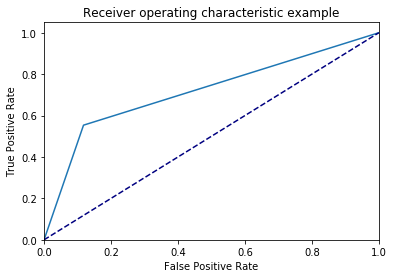

In [73]:
y_pred_knn_cont=clf3.predict(X_test_content)
evaluate_method(y_test,y_pred_knn_cont)
plot_roc(y_test,y_pred_knn_cont)

### 2) Support vector machine 

F-measure=  0.6451020274260219
Accuracy=  0.7031121356825293
auc= 0.693642213584112


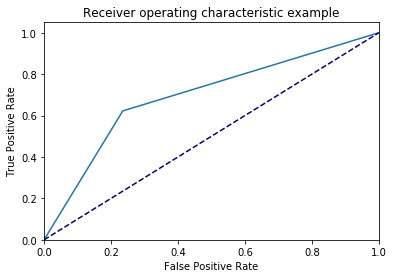

In [66]:
clf2=SVC(C=50, kernel='rbf', gamma=0.001)
clf2.fit(X_train_content, y_train)
y_pred_svm_content=clf2.predict(X_test_content)
evaluate_method(y_test,y_pred_svm_content)
plot_roc(y_test,y_pred_svm_content)

### 3) Linear discriminant analysis LDA 

In [67]:
clf5=LDA(n_components=1) 
clf5.fit(X_train_content,y_train)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

F-measure=  0.6565371449162213
Accuracy=  0.6860969317745211
auc= 0.6867985254981344


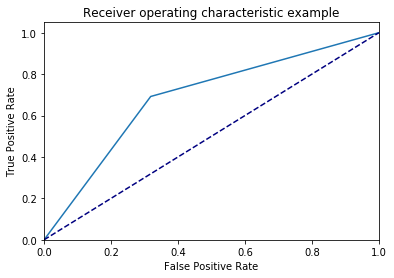

In [68]:
y_pred_lda=clf5.predict(X_test_content)
evaluate_method(y_test,y_pred_lda)
plot_roc(y_test,y_pred_lda)

### 4) Random forest 

In [69]:
rf=RandomForestClassifier(bootstrap=True,max_depth=30,max_features=2,min_samples_leaf=3,min_samples_split=100,n_estimators=1000)

F-measure=  0.648127213806617
Accuracy=  0.7437290740435809
auc= 0.7203363080811203


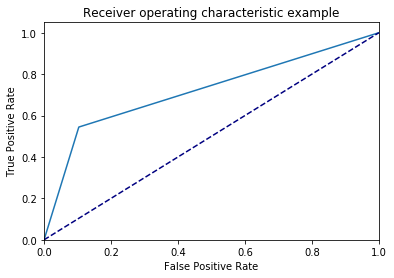

In [70]:
rf.fit(X_train_content, y_train)
y_pred_rf=rf.predict(X_test_content)
evaluate_method(y_test,y_pred_rf)
plot_roc(y_test,y_pred_rf)

## D. Classification with only content based features

### 1) Support vector Machine classifier 

**Tuning hyper-parameters using 5fold cross validation**

In [74]:
#grid search parameters 
Cs = [0.001, 0.01, 0.1, 1,10,50]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

In [92]:
warnings.filterwarnings('ignore')


print("# Tuning hyper-parameters")
print()
clf = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5,
                   scoring='f1')
clf.fit(X_scaled, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 50, 'gamma': 0.001}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 1}
0.000 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.000 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.557 (+/-0.017) for {'C': 0.01, 'gamma': 0.1}
0.498 (+/-0.024) for {'C': 0.01, 'gamma': 1}
0.000 (+/-0.000) for {'C': 0.1, 'gamma': 0.001}
0.648 (+/-0.012) for {'C': 0.1, 'gamma': 0.01}
0.629 (+/-0.015) for {'C': 0.1, 'gamma': 0.1}
0.584 (+/-0.016) for {'C': 0.1, 'gamma': 1}
0.666 (+/-0.005) for {'C': 1, 'gamma': 0.001}
0.668 (+/-0.007) for {'C': 1, 'gamma': 0.01}
0.658 (+/-0.011) for {'C': 1, 'gamma': 0.1}
0.625 (+/-0.009) for {'C': 1, 'gamma': 1}
0.670 (+/-0.007) for {'C': 10, 'gamma': 0.001}
0.669 (+/-0.007) for {'C': 10, 'gamma': 0.01}
0.660 (+/-0.014) f

**fitting with the optimized parameters and fitting** 

In [75]:
clf2=SVC(C=100, kernel='rbf', gamma=0.001)
clf2.fit(X_train, y_train) 

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

**Predicting and measuring performances** 

F-measure=  0.6447942849583278
Accuracy=  0.7052527581096657
auc= 0.6949073509648953


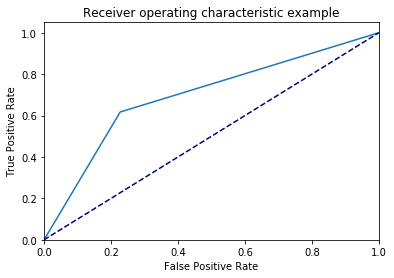

In [76]:
y_pred_svm=clf2.predict(X_test)
evaluate_method(y_test,y_pred_svm)
plot_roc(y_test,y_pred_svm)

**Plotting precision-recall curve**

AUPR=  0.582578130462423


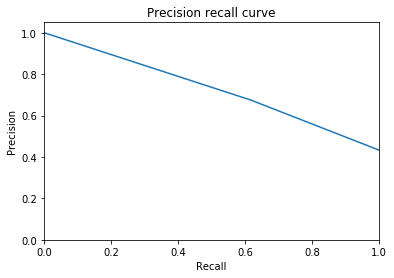

In [78]:
plot_prec_recall_curve(y_test,y_pred_svm)

### 2) K-nearest neighbors 

**Tuning hyper-parameters using 5-fold cross validation** 

In [193]:
KNeighborsClassifier(n_neighbors=5)
neigbors = [15,51,81,101,301,1001]
param_grid = {'n_neighbors': neigbors}      
print("# Tuning hyper-parameters for f_measure")
print()
clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                   scoring='f1')
clf.fit(X_scaled, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for f_measure

Best parameters set found on development set:

{'n_neighbors': 15}

Grid scores on development set:

0.614 (+/-0.017) for {'n_neighbors': 15}
0.603 (+/-0.016) for {'n_neighbors': 51}
0.595 (+/-0.019) for {'n_neighbors': 81}
0.598 (+/-0.021) for {'n_neighbors': 101}
0.551 (+/-0.014) for {'n_neighbors': 301}
0.528 (+/-0.022) for {'n_neighbors': 1001}



**Training with the optimized hyper-parameters and fitting** 

In [79]:
clf3=KNeighborsClassifier(n_neighbors=15)
clf3.fit(X_scaled, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

**Prediction and measuring performances**

F-measure=  0.6400342416892566
Accuracy=  0.7230363905812613
auc= 0.7048369521200557


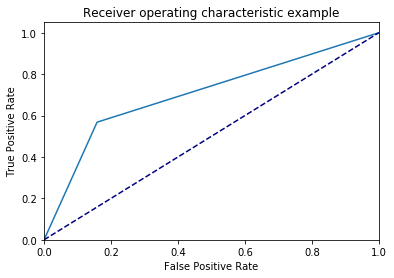

In [80]:
y_pred_knn=clf3.predict(X_test)
evaluate_method(y_test,y_pred_knn)
plot_roc(y_test,y_pred_knn)

**Plotting precision-recall curve**

AUPR=  0.6036187911309334


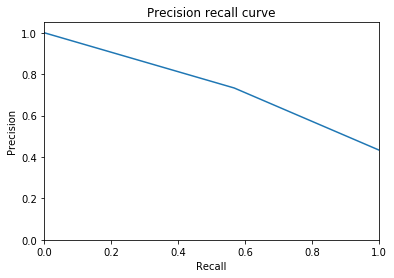

In [81]:
plot_prec_recall_curve(y_test,y_pred_knn)

### 3) Training Discriminant analysis LDA 

In [84]:
clf5=LDA(n_components=1) 
clf5.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

**Prediction and measuring performances for LDA**

F-measure=  0.6563478679836183
Accuracy=  0.6868104725835666
auc= 0.6871756512136661


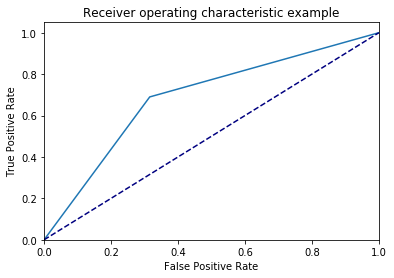

In [86]:
y_pred_lda=clf5.predict(X_test)
evaluate_method(y_test,y_pred_lda)
plot_roc(y_test,y_pred_lda)


**Plotting precision recall curve**

AUPR=  0.566235209503008


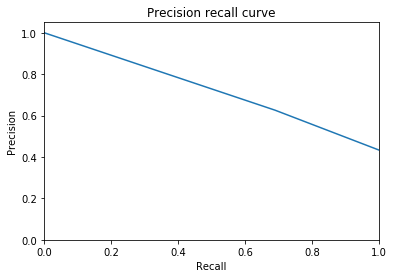

In [87]:
plot_prec_recall_curve(y_test,y_pred_lda)

### 4) Random forest 

**Tuning hyperparameters for Random Forest**

In [172]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier()

In [178]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   4.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   4.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_d

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   4.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   4.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   4.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   8.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.9min


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   4.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   4.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   9.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   9.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 31.5min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   4.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   5.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   5.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=  10.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samp

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 56.0min


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   9.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=  46.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=  13.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=  13.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 74.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [182]:
best_grid = grid_search.best_params_
best_grid

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 100}

**Training Random forest with the tuned hyperparametrers**

In [88]:
rf=RandomForestClassifier(bootstrap=True,max_depth=30,max_features=15,min_samples_leaf=30,min_samples_split=100,n_estimators=1000)

In [89]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Prediction , measuring performances and ROC curve**

F-measure=  0.6483921982076964
Accuracy=  0.7437290740435809
auc= 0.720410619322336


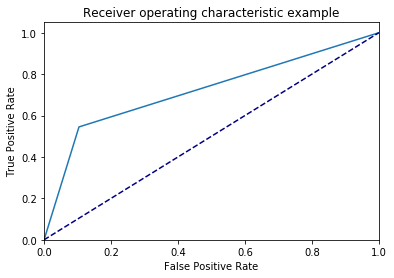

In [90]:
y_pred_rf=rf.predict(X_test)
evaluate_method(y_test,y_pred_rf)
plot_roc(y_test,y_pred_rf)

**Plotting precision recall curve** 

AUPR=  0.6332917232687572


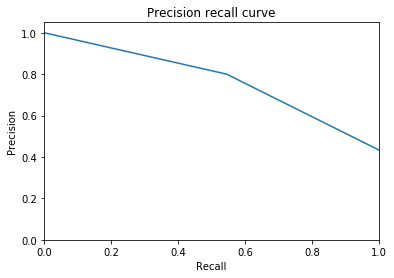

In [91]:
plot_prec_recall_curve(y_test,y_pred_rf)